# Import libraries

In [1]:
!pip install bertopic[gensim]
from bertopic import BERTopic

     |████████████████████████████████| 57 kB 2.1 MB/s 
     |████████████████████████████████| 88 kB 2.9 MB/s 
     |████████████████████████████████| 79 kB 5.6 MB/s 
     |████████████████████████████████| 5.2 MB 37.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.0 MB 33.8 MB/s 
     |████████████████████████████████| 1.2 MB 44.2 MB/s 
     |████████████████████████████████| 77 kB 6.1 MB/s 
     |████████████████████████████████| 895 kB 41.7 MB/s 
     |████████████████████████████████| 6.6 MB 34.7 MB/s 
     |████████████████████████████████| 636 kB 43.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.2 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330835 sha256=5cae8feb3177d59ba245d386ba0265e5db8e2afca2983de50a584101a78c6b09
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef

In [2]:
import pandas as pd
import numpy as np
import spacy

import re
import seaborn as sns 
from matplotlib import pyplot as plt

from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and preprocess data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/TFM/abstracts.csv", sep=";")
#Drop repo, keep only abstracts and label
abstracts = df.drop('Repo', axis=1)
print(abstracts.shape)
abstracts.head()

(25828, 2)


,Text,Label
0,"""https://paperswithcode.com/method/multiple-ra...",General
1,"""https://paperswithcode.com/method/dblock DBlo...",General
2,"""https://paperswithcode.com/method/gan-tts GAN...",Sequential
3,"""https://paperswithcode.com/method/conditional...",General
4,"""https://paperswithcode.com/method/gblock GBlo...",General


In [5]:
abstracts = abstracts[abstracts['Label'] != 'General']
print(abstracts.shape)

(17932, 2)


In [6]:
print(sum(abstracts.duplicated()))
print(sum(abstracts.duplicated(subset='Text')))

16956
16956


The number of duplicates considering both the abstract and the labels match with the duplicates just considering the abstracts. This means there aren't multilabels rather there were many reposirories that had the same abstract.

In [7]:
no_dups = abstracts.drop_duplicates()
no_dups = no_dups.reset_index(drop=True)

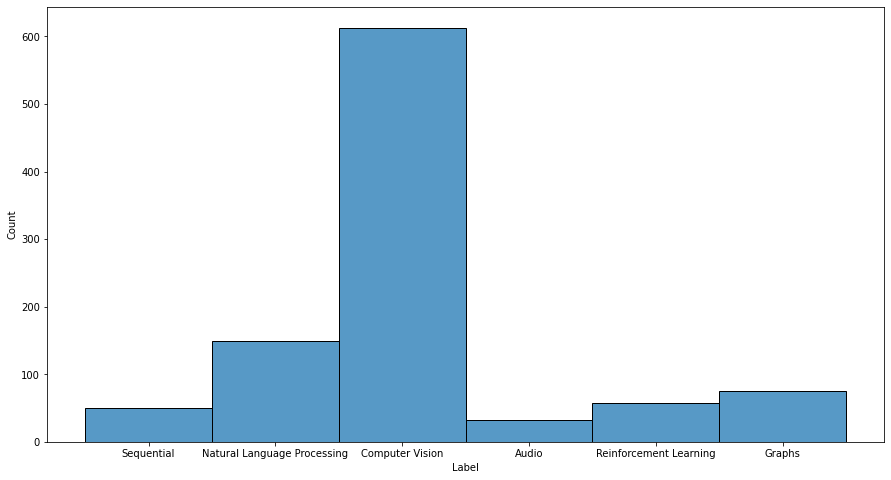

In [ ]:
plt.figure(figsize=(15,8))
sns.histplot(x='Label',data=no_dups)

In [8]:
def cleaner(text):
    """
    Preprocess the abstracts
    """
    #Title repeated 3 times at beginning?
    #Remove links
    text = re.sub(r'https:\S+',' ',str(text))
    #Remove equations
    text = re.sub(r'(\$[^$]+\$)|(\$\$[^$]+\$\$)',' ',text)
    #Remove common abbreviations
    text = re.sub(r'i\.e\.|e\.g\.|etc.',' ',text)
    #Remove special characters
    text = re.sub(r'\W',' ',text)
    #Remove words with only one character
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    #Change text to lower case
    text = text.lower()
    return text

In [9]:
#Preprocess
docs = no_dups.Text.apply(cleaner)
result = pd.DataFrame(docs)

# BERT

"BERTopic is a topic modeling technique that leverages BERT embeddings and c-TF-IDF to create dense clusters allowing for easily interpretable topics while keeping important words in the topic descriptions."

The default model in BERTopic ("all-MiniLM-L6-v2") works great for English documents

In [10]:
#14 s
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 123)
topic_model = BERTopic(umap_model=umap_model)
topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,Topic,Count,Name
0,0,921,0_the_of_to_none
1,1,55,1_the_policy_none_is


In [11]:
topic_model.visualize_barchart(topics=[0,1])

# Less memory

Set the minimum frequency of words in the CountVectorizer class to reduce the size of the resulting sparse c-TF-IDF matrix and significantly reduce memory

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
#11 s
#min_df = minimum frequency of words
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 3400)
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=5)
topic_model_2 = BERTopic(vectorizer_model=vectorizer_model,
                         umap_model=umap_model)#si sigue tardando set calculate_probabilities=False
topics, probs = topic_model_2.fit_transform(docs)
topic_model_2.get_topic_info()


,Topic,Count,Name
0,0,475,0_feature__network_object
1,1,110,1_language_model_pre_lstm
2,2,90,2_graph_networks_neural_neural networks
3,3,68,3_style_adversarial_image_generative
4,4,54,4_policy_learning_reinforcement_state
5,5,47,5_attention_transformer_self attention_self
6,-1,44,-1_convolution_text_temporal_recognition
7,6,38,6_text_decoder_model_end
8,7,27,7_augmentation_data augmentation_data_image
9,8,12,8_latent_hierarchical_encoder_auto


In [15]:
topic_model_2.visualize_barchart(topics = range(0,10))

In [ ]:
topic_model_2.visualize_topics()

In [ ]:
topic_model_2.visualize_heatmap()

In [16]:
topics_per_class = topic_model_2.topics_per_class(docs, topics, classes=no_dups['Label'])
topic_model_2.visualize_topics_per_class(topics_per_class,topics= range(0,10))

NLP 1,5 \\
Sequential 1, \\
Audio 6 \\
Reinforcement learning 4  \\
Graphs 2, \\
Computer vision 0,3 (7, 8 descarte) \\

# Sentence Transformers

In [17]:
#27 s
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("all-mpnet-base-v2")

topic_model_6 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         umap_model=umap_model,
                         calculate_probabilities = False,
                         nr_topics="auto"
                        )

topics, probs = topic_model_6.fit_transform(docs)
topic_model_6.get_topic_info()

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

,Topic,Count,Name
0,0,515,0_feature__attention_network
1,1,155,1_image_adversarial_generative_
2,2,95,2_language_model_word_pre
3,3,89,3_graph_networks_neural_
4,4,52,4_learning_reinforcement_state_reinforcement l...
5,-1,36,-1_language_lstm__model
6,5,21,5_lstm_recurrent_temporal_time
7,6,13,6_variational_autoencoder_latent_hierarchical


In [18]:
topics_per_class = topic_model_6.topics_per_class(docs, topics, classes=no_dups['Label'])
topic_model_6.visualize_topics_per_class(topics_per_class,topics=range(0,7))

NLP 2, \\
Sequential 5, \\
Audio 1 \\
Reinforcement learning 4, \\
Graphs 3, \\
Computer vision 0, \\

In [20]:
#29 s
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       min_dist=0.0,
                       metric='cosine',
                       low_memory= False, 
                       random_state = 9800)
sentence_model = SentenceTransformer("allenai-specter")

topic_model_7 = BERTopic(vectorizer_model=vectorizer_model,
                         embedding_model=sentence_model,
                         nr_topics="auto" #reduce number topics automatically
                        )

topics, probs = topic_model_7.fit_transform(docs)
topic_model_7.get_topic_info()

,Topic,Count,Name
0,0,512,0__network_model_image
1,-1,204,-1_feature__image_network
2,1,106,1_detection_feature_stage_backbone
3,2,67,2_graph_networks_neural_neural networks
4,3,48,3_attention_transformer_self attention_self
5,4,24,4_transformer_attention_self attention_self
6,5,15,5_resnet_reduction_impact_v2


In [21]:
topics_per_class = topic_model_7.topics_per_class(docs, topics, classes=no_dups['Label'])
topic_model_7.visualize_topics_per_class(topics_per_class,topics =range(0,6))